In [1]:
import pickle
import numpy as np
import pandas as pd
import re
import string
from gensim.parsing.preprocessing import remove_stopwords
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
!pip install pyLDAvis
import spacy
nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline


In [8]:
data = pd.read_pickle("topics_per_doc.pkl")
data

,review_body,sentiment,product_parent,discipline,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,Review based on a cursory examination by Unive...,4,598678717,psychology,0,7.0,0.3387,"book, use, chapter, student, text, information...","[review, base, cursory, examination, universit..."
1,ALthough he is correct that the IMF and World ...,3,697870179,economy,1,15.0,0.2844,"social, work, society, theory, culture, study,...","[correct, play, role, also, advocate, reform, ..."
2,While I don't always agree with his TV analysi...,2,339619920,politics,2,14.0,0.4312,"people, say, make, even, fact, see, believe, r...","[always, agree, tv, analysis, enjoy, book, how..."
3,Since the 1992 presidential run of H. Ross Per...,4,733918058,economy,3,17.0,0.2147,"economy, economic, world, global, policy, coun...","[presidential, run, ross_perot, grow, awarenes..."
4,In terms of programming concepts and OOP desig...,3,82232603,economy,4,2.0,0.2886,"model, theory, analysis, mathematical, finance...","[term, programming, concept, oop, engineering,..."
...,...,...,...,...,...,...,...,...,...
42465,This book captures the reality of the American...,5,218513537,politics,42465,4.0,0.4869,"book, read, write, author, well, reader, find,...","[book, capture, reality, american, primary, sy..."
42466,"Based on anecdotal evidence, intuition, tradit...",4,426467516,psychology,42466,14.0,0.3120,"people, say, make, even, fact, see, believe, r...","[base, intuition, tradition, faith, reincarnat..."
42467,An excellent monograph by an outstanding scholar,5,232298383,politics,42467,4.0,0.2257,"book, read, write, author, well, reader, find,...","[excellent, monograph, outstanding, scholar]"
42468,The authors write with clarity in a field whic...,4,323732312,politics,42468,4.0,0.3269,"book, read, write, author, well, reader, find,...","[author, write, clarity, field, academic, prac..."


In [25]:
data.groupby(["Dominant_Topic"])["sentiment"].agg('mode')

AttributeError: 'SeriesGroupBy' object has no attribute 'mode'

In [16]:
data.groupby(["discipline"])["Dominant_Topic"].agg(pd.Series.mode).to_frame()

,Dominant_Topic
discipline,
anthropology,4.0
economy,0.0
politics,4.0
psychology,0.0
sociology,15.0


In [15]:
data.groupby(["Dominant_Topic"])["discipline"].agg(pd.Series.mode).to_frame()

,discipline
Dominant_Topic,
0.0,economy
1.0,sociology
2.0,economy
3.0,politics
4.0,politics
5.0,economy
6.0,economy
7.0,economy
8.0,sociology


In [5]:
data.groupby(["Dominant_Topic"])["sentiment"].agg(pd.Series.mode).to_frame()

,sentiment
Dominant_Topic,
0.0,5
1.0,4
2.0,4
3.0,4
4.0,4
5.0,4
6.0,4
7.0,4
8.0,1


<AxesSubplot:xlabel='Dominant_Topic', ylabel='sentiment'>

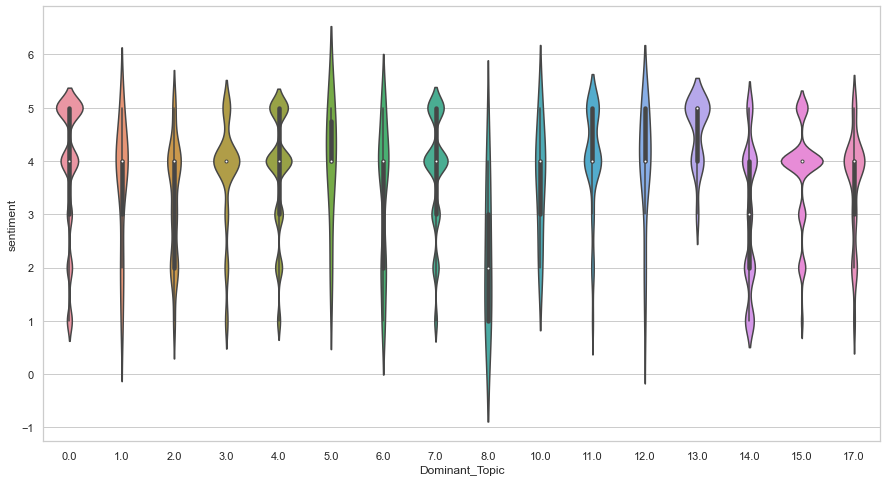

In [47]:
import seaborn
    
    
seaborn.set(style = 'whitegrid',rc={'figure.figsize':(15,8)})

seaborn.violinplot(x ="Dominant_Topic",
             y ="sentiment",
             data = data)

<AxesSubplot:xlabel='Dominant_Topic'>

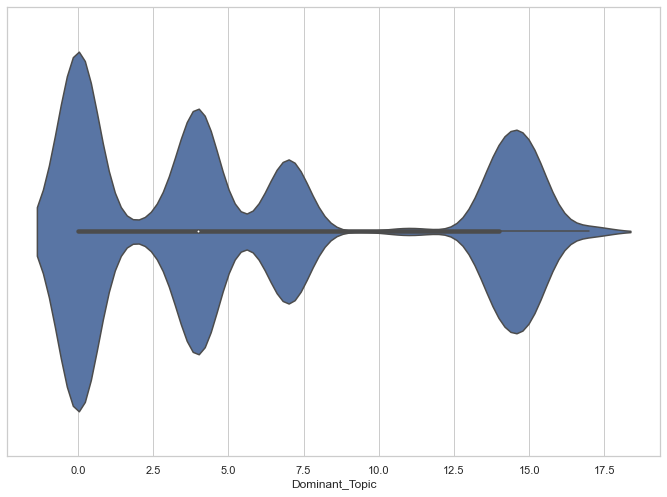

In [39]:
import seaborn
 
# use to set style of background of plot
seaborn.set(style="whitegrid",rc={'figure.figsize':(11.7,8.27)})
 
seaborn.violinplot(x=data["Dominant_Topic"])

Text(0.5, 1.0, 'Topic Distribution By Sentiment')

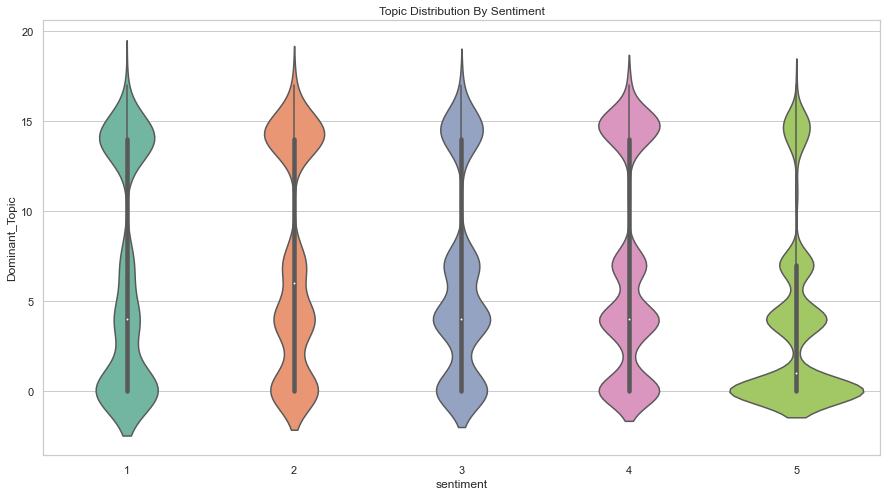

In [46]:
import seaborn
 
# background of plot
seaborn.set(style="whitegrid",rc={'figure.figsize':(15,8)})


 
ax = seaborn.violinplot(x="sentiment", y="Dominant_Topic",
                   data=data, palette="Set2", dodge=True)

ax.set_title("Topic Distribution By Sentiment")

In [7]:
data.describe()
print(data['Dominant_Topic'].unique())

[ 0. 15. 14.  6.  7.  3.  4.  2.  1. 18. 12. 16. 11.  5. 13. 10.  8.  9.]


In [14]:
# sentiment

data.groupby("discipline")["sentiment"].agg('mean')

discipline
anthropology    3.860550
economy         3.744935
politics        3.635723
psychology      3.960693
sociology       3.803074
Name: sentiment, dtype: float64

In [18]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=data, width=.5, color='firebrick')
ax1.set_xticks(range(data.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

NameError: name 'df_topic_weightage_by_doc' is not defined

NameError: name 'df_top3words' is not defined

<Figure size 1200x480 with 2 Axes>